In [7]:
# ===================================================================
# # 1. Imports
# This section contains all the needed packages and handles installation.
# ===================================================================
import subprocess
import sys
import os
import glob
import time

# Install required packages
print("--- Installing required packages ---")
required = [
    "torch", "torchvision", "timm", "opencv-python", "numpy", "scipy",
    "scikit-learn", "matplotlib", "Pillow", "tqdm", "scikit-image", "distinctipy", "pandas"
]
for pkg in required:
    try:
        import_name = pkg.split('-')[0]
        if pkg == 'scikit-learn': import_name = 'sklearn'
        __import__(import_name)
    except ImportError:
        print(f"Installing {pkg}...")
        subprocess.run([sys.executable, "-m", "pip", "install", pkg], check=True)
print("--- All packages are ready ---\n")

# Import all libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import distinctipy



--- Installing required packages ---
Installing opencv-python...
Installing Pillow...
Installing scikit-image...
--- All packages are ready ---



In [8]:
# ===================================================================
# # 2. Globals
# This section contains useful variables for the whole code.
# ===================================================================
# --- Device and Seed ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# --- File Paths and Folders ---
DATASET_FOLDER = "silk_dataset"
PROCESSED_DATA_FOLDER = "data/processed_for_feed_classification"
CSV_FILE_PATH = "0_data.csv" 

# --- SPEED OPTIMIZATION ---
DATA_GENERATION_SUBSET = 200 

# --- Images for Unsupervised Evaluation Demo ---
TEST_IMAGE_FILENAMES = ["img_2711.jpg", "img_2849.jpg", "img_2868.jpg", "img_3009.jpg"]

# --- Training Configuration ---
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
VAL_SPLIT = 0.2

# --- Create standard folders ---
folders = ["results/visualizations", "results/segmentation", "models/checkpoints", PROCESSED_DATA_FOLDER]
for folder in folders:
    os.makedirs(folder, exist_ok=True)

print(f"Device set to: {DEVICE}")



Device set to: cuda


In [9]:
# ===================================================================
# # 3. Utils
# This section contains code support functions (helpers).
# ===================================================================
def plot_segmentation_visualization(image_path, results):
    """Plots the original image alongside all U2Seg segmentation results."""
    orig = np.array(Image.open(image_path).convert("RGB"))
    semantic_names = results['semantic_names']
    colors = {'silkworms': [255, 80, 80], 'leaves': [80, 255, 80], 'background': [80, 80, 255]}
    raw_instances = results['raw_instances']; instance_colors = distinctipy.get_colors(len(raw_instances), colorblind_type="Deuteranomaly")
    raw_instance_overlay = np.zeros_like(orig, dtype=np.float32)
    for i, mask in enumerate(raw_instances): raw_instance_overlay[mask > 0] = instance_colors[i]
    raw_instance_img = (raw_instance_overlay * 0.7 + orig / 255.0 * 0.3)
    semantic_map = results['semantic_map']; semantic_overlay = np.zeros_like(orig, dtype=np.float32)
    for i, name in enumerate(semantic_names): semantic_overlay[semantic_map == i] = np.array(colors.get(name, [128, 128, 128])) / 255.0
    semantic_img = (semantic_overlay * 0.5 + orig / 255.0 * 0.5)
    final_overlay = np.zeros_like(orig, dtype=np.float32)
    for name, masks in results['classified_instances'].items():
        color = np.array(colors.get(name, [128, 128, 128])) / 255.0
        for mask in masks: final_overlay[mask > 0] = color
    final_instance_img = (final_overlay * 0.5 + orig / 255.0 * 0.5)
    f, ax = plt.subplots(1, 4, figsize=(24, 6))
    ax[0].imshow(orig); ax[0].set_title(f"Original: {os.path.basename(image_path)}"); ax[1].imshow(raw_instance_img); ax[1].set_title(f"Raw Instances ({len(raw_instances)} found)"); ax[2].imshow(semantic_img); ax[2].set_title("Semantic Segmentation"); ax[3].imshow(final_instance_img); ax[3].set_title("Final Merged Segmentation")
    for a in ax: a.axis("off"); plt.tight_layout(); plt.show()

def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if batch else (None, None)

def find_all_images(dataset_folder):
    exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    return sorted([p for ext in exts for p in glob.glob(os.path.join(dataset_folder, f"*{ext}"))])

def prepare_data_for_feed_classification(pipeline, labels_df, output_folder, max_images=None):
    """
    Runs segmentation and saves each instance into a folder named after the
    scene-level "feed" or "not feed" label from the CSV file.
    """
    print(f"\n--- Generating dataset for 'Feed' vs. 'Not Feed' classification ---")
    
    # Create a mapping from image filename to its label for quick lookup
    label_map = {row['foto']: row['classificazione'] for _, row in labels_df.iterrows()}
    image_paths = [os.path.join(DATASET_FOLDER, f) for f in label_map.keys() if os.path.exists(os.path.join(DATASET_FOLDER, f))]
    
    if max_images and max_images < len(image_paths):
        print(f"Processing a random subset of {max_images} images for speed.")
        image_paths = np.random.choice(image_paths, max_images, replace=False)
    
    instance_count = 0; start_time = time.time()
    for image_path in tqdm(image_paths, desc="Segmenting images and labeling by scene"):
        try:
            scene_label = label_map.get(os.path.basename(image_path))
            if scene_label is None: continue # Skip if image not in CSV

            with Image.open(image_path) as img:
                img.thumbnail((1024, 1024)); original_image = np.array(img.convert('RGB'))
            
            results = pipeline.merge_and_segment(original_image)
            if not results: continue

            # The folder name will be '0_not_feed' or '1_feed'
            class_folder_name = f"{scene_label}_{'feed' if scene_label == 1 else 'not_feed'}"
            class_dir = os.path.join(output_folder, class_folder_name)
            os.makedirs(class_dir, exist_ok=True)

            # Save all segmented objects from this image into the correct scene-level folder
            for category, masks in results['classified_instances'].items():
                if category == 'background': continue
                for i, mask in enumerate(masks):
                    rows, cols = np.where(mask)
                    if len(rows) == 0: continue
                    rmin, rmax, cmin, cmax = rows.min(), rows.max(), cols.min(), cols.max()
                    instance_crop = original_image[rmin:rmax+1, cmin:cmax+1]; mask_crop = mask[rmin:rmax+1, cmin:cmax+1]
                    rgba_instance = np.zeros((*instance_crop.shape[:2], 4), dtype=np.uint8)
                    rgba_instance[:, :, :3] = instance_crop; rgba_instance[:, :, 3] = mask_crop * 255
                    Image.fromarray(rgba_instance).save(os.path.join(class_dir, f"{os.path.basename(image_path).split('.')[0]}_{category}_{i}.png")); instance_count += 1
        except Exception as e:
            print(f"Could not process {image_path}: {e}")
    
    print(f"--- Finished. Saved {instance_count} instances in {time.time() - start_time:.2f} seconds. ---")
    return instance_count



In [10]:
# ===================================================================
# # 4. Data
# This section handles everything related to data management.
# ===================================================================
class UnsupervisedInstanceSegmentation:
    def __init__(self, tau=0.05, n_clusters=80, min_size=50): self.tau, self.n_clusters, self.min_size, self.eps = tau, n_clusters, min_size, 1e-8
    def _compute_affinity(self, features): H, W, D = features.shape; X = features.reshape(-1, D); X = X / (np.linalg.norm(X, axis=1, keepdims=True) + self.eps); aff = np.dot(X, X.T); aff = np.maximum(aff - self.tau, 0); aff[np.diag_indices_from(aff)] += self.eps; return aff
    def _spectral_clustering(self, aff): degree = np.sum(aff, axis=1); D_inv_sqrt = np.diag(1.0 / (np.sqrt(degree) + self.eps)); norm_aff = D_inv_sqrt @ aff @ D_inv_sqrt; k = min(self.n_clusters, norm_aff.shape[0] - 2); _, eigvecs = eigsh(norm_aff, k=k, which='LM'); kmeans = KMeans(n_clusters=self.n_clusters, random_state=42, n_init='auto', max_iter=400); return kmeans.fit_predict(eigvecs)
    def generate_all_instances(self, features, target_shape): H_feat, W_feat, _ = features.shape; target_h, target_w = target_shape; aff = self._compute_affinity(features); labels = self._spectral_clustering(aff); label_map_coarse = labels.reshape(H_feat, W_feat); label_map_full = cv2.resize(label_map_coarse.astype(np.uint8), (target_w, target_h), interpolation=cv2.INTER_NEAREST); return [mask for label_id in np.unique(label_map_full) if (mask := (label_map_full == label_id)).sum() > self.min_size]

class UnsupervisedSemanticSegmentation:
    def __init__(self, tau=0.12, n_classes=3): self.tau, self.n_classes, self.eps = tau, n_classes, 1e-8; self.semantic_names = ['background', 'leaves', 'silkworms']
    def _compute_affinity(self, features): H, W, D = features.shape; X = features.reshape(-1, D); X = X / (np.linalg.norm(X, axis=1, keepdims=True) + self.eps); aff = np.dot(X, X.T); aff = np.maximum(aff - self.tau, 0); aff[np.diag_indices_from(aff)] += self.eps; return aff
    def _spectral_clustering(self, aff, target_h, target_w): degree = np.sum(aff, axis=1); D_inv_sqrt = np.diag(1.0 / (np.sqrt(degree) + self.eps)); norm_aff = D_inv_sqrt @ aff @ D_inv_sqrt; _, eigvecs = eigsh(norm_aff, k=self.n_classes, which='LM'); H_feat, W_feat = int(np.sqrt(aff.shape[0])), int(np.sqrt(aff.shape[0])); eigvecs_reshaped = eigvecs.reshape(H_feat, W_feat, self.n_classes); eigvecs_resized = cv2.resize(eigvecs_reshaped, (target_w, target_h), interpolation=cv2.INTER_LINEAR); kmeans = KMeans(n_clusters=self.n_classes, random_state=42, n_init='auto'); return kmeans.fit_predict(eigvecs_resized.reshape(-1, self.n_classes)).reshape(target_h, target_w)
    def _label_categories(self, label_map, original_image):
        hsv_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2HSV); cluster_props = {}
        for i in range(self.n_classes):
            mask = (label_map == i)
            if mask.any(): cluster_props[i] = {'hue': np.mean(hsv_image[:,:,0][mask]), 'sat': np.mean(hsv_image[:,:,1][mask])}
        valid_labels = list(cluster_props.keys()); label_to_name = {}
        if not valid_labels: return {}
        leaf_label = min(valid_labels, key=lambda k: abs(cluster_props[k]['hue'] - 60)); label_to_name[leaf_label] = 'leaves'; valid_labels.remove(leaf_label)
        if valid_labels: silkworm_label = min(valid_labels, key=lambda k: cluster_props[k]['sat']); label_to_name[silkworm_label] = 'silkworms'; valid_labels.remove(silkworm_label)
        if valid_labels: label_to_name[valid_labels[0]] = 'background'
        return label_to_name
    def generate_semantic_map(self, features, original_image): H_orig, W_orig, _ = original_image.shape; aff = self._compute_affinity(features); label_map = self._spectral_clustering(aff, H_orig, W_orig); label_to_name_map = self._label_categories(label_map, original_image); final_map = np.zeros_like(label_map); [final_map.__setitem__(label_map == label_idx, i) for i, name in enumerate(self.semantic_names) for label_idx, cat_name in label_to_name_map.items() if cat_name == name]; return final_map, self.semantic_names

class U2SegUnified:
    def __init__(self, extractor, instance_segmentor, semantic_segmentor): self.extractor, self.instance_segmentor, self.semantic_segmentor = extractor, instance_segmentor, semantic_segmentor
    def merge_and_segment(self, image_or_path):
        try:
            if isinstance(image_or_path, str): original_image = np.array(Image.open(image_or_path).convert('RGB'))
            else: original_image = image_or_path
            H, W, _ = original_image.shape; features = self.extractor.extract_features(Image.fromarray(original_image))
            if features is None: return None
            all_instances = self.instance_segmentor.generate_all_instances(features, target_shape=(H, W))
            semantic_map, semantic_names = self.semantic_segmentor.generate_semantic_map(features, original_image)
            classified_instances = {name: [] for name in semantic_names}
            for inst_mask in all_instances:
                instance_pixels = semantic_map[inst_mask > 0]
                if len(instance_pixels) == 0: continue
                best_semantic_id = np.argmax(np.bincount(instance_pixels, minlength=len(semantic_names)))
                classified_instances[semantic_names[best_semantic_id]].append(inst_mask)
            return {"raw_instances": all_instances, "classified_instances": classified_instances, "category_counts": {name: len(masks) for name, masks in classified_instances.items()}, "semantic_map": semantic_map, "semantic_names": semantic_names}
        except Exception as e: print(f"Error during segmentation: {e}"); return None



In [11]:
# ===================================================================
# # 5. Network
# This section contains the code to structure the neural networks.
# ===================================================================
class DINOFeatureExtractor:
    def __init__(self, model_name='dinov2_vitb14', device='cuda'):
        self.device = device; self.model = torch.hub.load('facebookresearch/dinov2', model_name, pretrained=True).to(device).eval()
        self.transform = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.patch_size, self.spatial_dim = 14, 518 // 14
    def extract_features(self, image):
        try:
            tensor = self.transform(image).unsqueeze(0).to(self.device)
            with torch.no_grad(): patch_features = self.model.forward_features(tensor)['x_norm_patchtokens']
            return patch_features.reshape(1, self.spatial_dim, self.spatial_dim, -1).squeeze(0).cpu().numpy()
        except Exception: return None

class SceneClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SceneClassifier, self).__init__()
        weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        self.mobilenet = models.mobilenet_v3_small(weights=weights)
        for param in self.mobilenet.parameters(): param.requires_grad = False
        in_features = self.mobilenet.classifier[-1].in_features
        self.mobilenet.classifier[-1] = nn.Linear(in_features, num_classes)
        self.transform = weights.transforms()
    def forward(self, x): return self.mobilenet(x)



In [12]:
# ===================================================================
# # 6. Train
# This section contains the training cycle for the classifier.
# ===================================================================
print("\n--- Preparing for 'Feed vs. Not Feed' Classification ---")
try:
    labels_df = pd.read_csv(CSV_FILE_PATH)
except FileNotFoundError:
    print(f"FATAL ERROR: CSV file not found at '{CSV_FILE_PATH}'. Cannot proceed.")
    labels_df = None

if labels_df is not None:
    segmentation_feature_extractor = DINOFeatureExtractor(device=DEVICE)
    instance_segmentor = UnsupervisedInstanceSegmentation(n_clusters=150, min_size=100)
    semantic_segmentor = UnsupervisedSemanticSegmentation(n_classes=3)
    u2seg_pipeline = U2SegUnified(segmentation_feature_extractor, instance_segmentor, semantic_segmentor)
    num_instances = prepare_data_for_feed_classification(u2seg_pipeline, labels_df, PROCESSED_DATA_FOLDER, max_images=DATA_GENERATION_SUBSET)

    model = None
    if num_instances > 0:
        try:
            classifier_model = SceneClassifier(num_classes=2); data_transform = classifier_model.transform
            full_dataset = ImageFolder(PROCESSED_DATA_FOLDER, transform=data_transform)
            class_names = full_dataset.classes; num_classes = len(class_names)
            print(f"\nCreated dataset with {len(full_dataset)} instances for {num_classes} classes: {class_names}")

            if len(full_dataset) > 1:
                val_size = int(len(full_dataset) * VAL_SPLIT); train_size = len(full_dataset) - val_size
                train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
                train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
                val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)
                print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
                
                model = SceneClassifier(num_classes=num_classes).to(DEVICE)
                criterion = nn.CrossEntropyLoss(); optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
                
                print("\n--- Starting model training ---")
                for epoch in range(NUM_EPOCHS):
                    model.train(); running_loss, num_samples = 0.0, 0
                    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
                        if inputs is None: continue
                        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                        optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
                        loss.backward(); optimizer.step(); running_loss += loss.item() * inputs.size(0); num_samples += inputs.size(0)
                    if num_samples > 0: print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Training Loss: {running_loss / num_samples:.4f}")
                print("--- Training finished ---")
            else: print("\nERROR: Not enough instances found to train the model.")
        except Exception as e: print(f"\nAn error occurred during training preparation: {e}")
    else: print("\nERROR: No instances were generated. Cannot train.")




--- Preparing for 'Feed vs. Not Feed' Classification ---


Using cache found in C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main



--- Generating dataset for 'Feed' vs. 'Not Feed' classification ---
Processing a random subset of 200 images for speed.


Segmenting images and labeling by scene: 100%|███████████████████████████████████████| 200/200 [28:07<00:00,  8.44s/it]


--- Finished. Saved 19616 instances in 1687.93 seconds. ---

Created dataset with 36833 instances for 2 classes: ['0_not_feed', '1_feed']
Train samples: 29467, Validation samples: 7366

--- Starting model training ---


Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 921/921 [10:54<00:00,  1.41it/s]


Epoch 1/5 - Training Loss: 0.5100


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 921/921 [07:02<00:00,  2.18it/s]


Epoch 2/5 - Training Loss: 0.5003


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 921/921 [07:13<00:00,  2.12it/s]


Epoch 3/5 - Training Loss: 0.4972


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 921/921 [07:10<00:00,  2.14it/s]


Epoch 4/5 - Training Loss: 0.4994


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 921/921 [07:25<00:00,  2.07it/s]

Epoch 5/5 - Training Loss: 0.4967
--- Training finished ---




--- Evaluating Classifier on Segmented Instances ---
--- Classification Performance Metrics ---
Overall Accuracy: 0.7577

Confusion Matrix:
 [[2055 1139]
 [ 646 3526]]

--- Per-Class Metrics ---
Class        |  Precision |     Recall |   F1-Score |  Specificity |        FPR
--------------------------------------------------------------------------------
0_not_feed   |     0.7608 |     0.6434 |     0.6972 |       0.8452 |     0.1548
1_feed       |     0.7558 |     0.8452 |     0.7980 |       0.6434 |     0.3566


--- Evaluating Unsupervised Segmentation Pipeline (Demonstration) ---


Using cache found in C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main



Processing image for segmentation demo: silk_dataset\img_2711.jpg...
--- U2Seg Merged Results ---
Found 69 instances of 'background'
Found 61 instances of 'leaves'
Found 20 instances of 'silkworms'


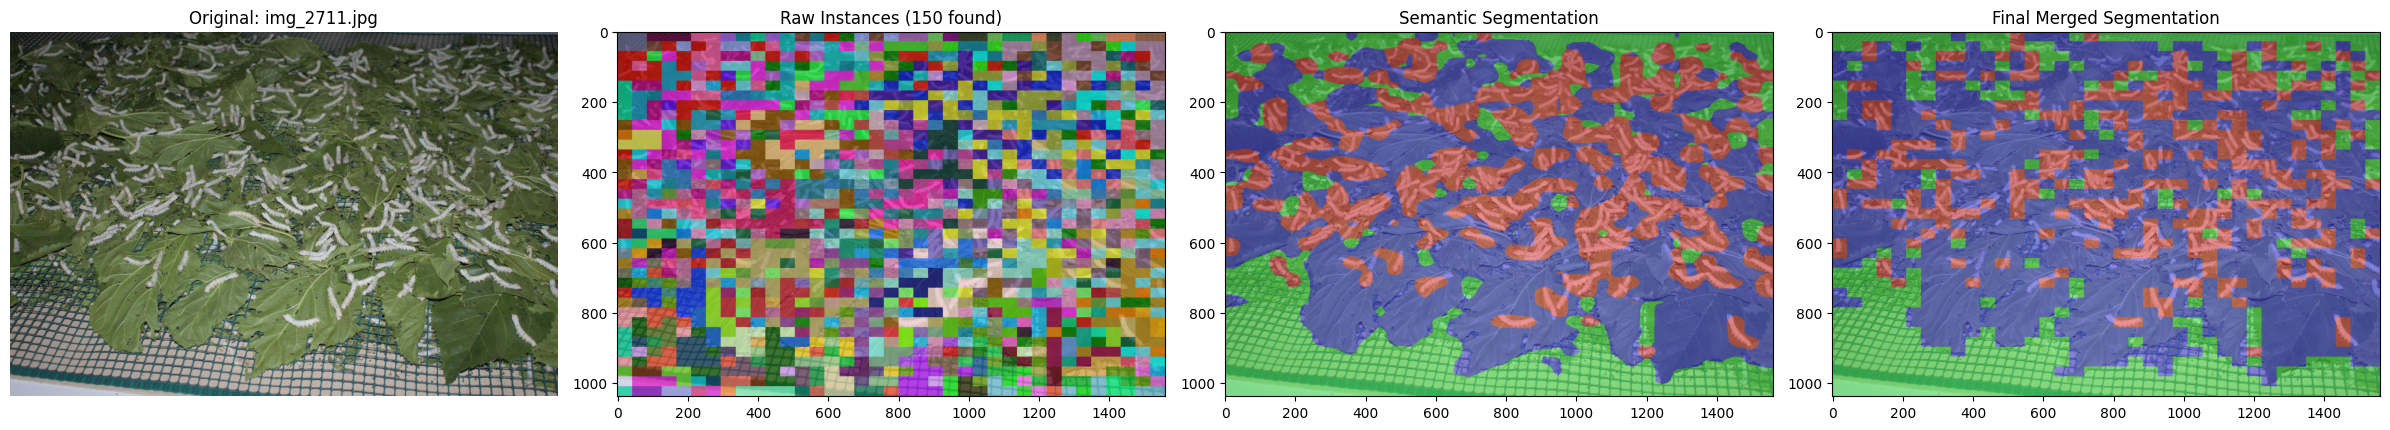

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Processing image for segmentation demo: silk_dataset\img_2849.jpg...
--- U2Seg Merged Results ---
Found 38 instances of 'background'
Found 50 instances of 'leaves'
Found 62 instances of 'silkworms'


In [ ]:
# ===================================================================
# # 7. Evaluation
# This section contains tests for the trained network and the
# original unsupervised segmentation pipeline for demonstration.
# ===================================================================
if model is not None and 'val_loader' in locals():
    print("\n\n--- Evaluating Classifier on Segmented Instances ---")
    model.eval(); all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            if inputs is None: continue
            outputs = model(inputs.to(DEVICE)); _, preds = torch.max(outputs, 1); all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.numpy())
    if all_labels:
        cm = confusion_matrix(all_labels, all_preds); accuracy = accuracy_score(all_labels, all_preds); precision = precision_score(all_labels, all_preds, average=None, zero_division=0); recall = recall_score(all_labels, all_preds, average=None, zero_division=0); f1 = f1_score(all_labels, all_preds, average=None, zero_division=0); fp = cm.sum(axis=0) - np.diag(cm); fn = cm.sum(axis=1) - np.diag(cm); tp = np.diag(cm); tn = cm.sum() - (fp + fn + tp)
        specificity = np.divide(tn, (tn + fp), out=np.zeros_like(tn, dtype=float), where=(tn + fp)!=0)
        fpr = np.divide(fp, (fp + tn), out=np.zeros_like(fp, dtype=float), where=(fp + tn)!=0)

        print("--- Classification Performance Metrics ---")
        print(f"Overall Accuracy: {accuracy:.4f}\n"); print("Confusion Matrix:\n", cm)
        print("\n--- Per-Class Metrics ---")
        print(f"{'Class':<12} | {'Precision':>10} | {'Recall':>10} | {'F1-Score':>10} | {'Specificity':>12} | {'FPR':>10}")
        print("-" * 80)
        for i, class_name in enumerate(class_names):
            print(f"{class_name:<12} | {precision[i]:10.4f} | {recall[i]:10.4f} | {f1[i]:10.4f} | {specificity[i]:12.4f} | {fpr[i]:10.4f}")
    else: print("--- No data in validation set to evaluate. ---")
else: print("\n--- Classifier evaluation skipped because training did not complete. ---")

print("\n\n--- Evaluating Unsupervised Segmentation Pipeline (Demonstration) ---")
segmentation_demo_pipeline = U2SegUnified(DINOFeatureExtractor(device=DEVICE), UnsupervisedInstanceSegmentation(n_clusters=150, min_size=100), UnsupervisedSemanticSegmentation(n_classes=3))
for filename in TEST_IMAGE_FILENAMES:
    image_path = os.path.join(DATASET_FOLDER, filename)
    if not os.path.exists(image_path): continue
    print(f"\nProcessing image for segmentation demo: {image_path}...")
    results = segmentation_demo_pipeline.merge_and_segment(image_path)
    if results:
        print("--- U2Seg Merged Results ---"); [print(f"Found {count} instances of '{name}'") for name, count in results['category_counts'].items()]
        plot_segmentation_visualization(image_path, results)
    else: print(f"Failed to process {image_path}.")
print("\n--- Full Evaluation Finished ---")
